# **SHAKESPEARE GPT** (3.22M Parameters)

In [ ]:
# import os
# import torch
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# torch.cuda.empty_cache()

## Read data, Character Integer conversion, Encoding

In [39]:
with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [40]:
print('Length of Dataset in characters: ', len(text))

Length of Dataset in characters:  1115393


In [41]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [42]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [43]:
# Tokeniser character-by-character.

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode('hii there'))
print(decode(encode('hii there')))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [44]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:200])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59])


## Train and validation set

In [45]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [46]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [47]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f':when input is {context} the target: {target}')

# We use this block size not only for efficient computational
# training but also for inference after training. 
# The transformer need to see a small piece of text
# all the way to block size and also in between.
# This will be helpful when inferencing because when we're
# sampling we can we can start the sampling generation
# with as little as one character of context and the transformer
# knows how to predict the next character with all the way up
# to just context of one ans so then it can predict 
# everything up to block size

# Note that if u train tranformer like this then the input also should 
# be fed maximum of block size then truncate it and send, if it is higher.

:when input is tensor([18]) the target: 47
:when input is tensor([18, 47]) the target: 56
:when input is tensor([18, 47, 56]) the target: 57
:when input is tensor([18, 47, 56, 57]) the target: 58
:when input is tensor([18, 47, 56, 57, 58]) the target: 1
:when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
:when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
:when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


## Get Batch of data

In [48]:
torch.manual_seed(1337)
batch_size = 4 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum input size that can be fed for a single inference?

def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs: ')
print(xb.shape)
print(xb)
print('targets: ')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f'When input is {context.tolist()} the target: {target}')

inputs: 
torch.Size([4, 8])
tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])
targets: 
torch.Size([4, 8])
tensor([[59,  6,  1, 58, 56, 47, 40, 59],
        [43, 43, 54,  1, 47, 58,  1, 58],
        [52, 45, 43, 50, 53,  8,  0, 26],
        [39,  1, 46, 53, 59, 57, 43,  0]])
----
When input is [53] the target: 59
When input is [53, 59] the target: 6
When input is [53, 59, 6] the target: 1
When input is [53, 59, 6, 1] the target: 58
When input is [53, 59, 6, 1, 58] the target: 56
When input is [53, 59, 6, 1, 58, 56] the target: 47
When input is [53, 59, 6, 1, 58, 56, 47] the target: 40
When input is [53, 59, 6, 1, 58, 56, 47, 40] the target: 59
When input is [49] the target: 43
When input is [49, 43] the target: 43
When input is [49, 43, 43] the target: 54
When input is [49, 43, 43, 54] the target: 1
When input is [49, 43, 43, 54, 1] the target: 47
When input is [49, 43

## Simple Bigram model using classes

In [49]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        
        # idx and targets are both (B,T) tensor of integers.
        logits = self.token_embedding_table(idx) # (B, T, C) (B --> Batch, T --> Time, C --> Channel) ---> (4, 8, 65)
        # Here to do the cross_entropy we need to convert logits from (B, T, C) --> (B, C, T)
        # So we're using view() to change the dimension to the suitable one.

        if targets == None:
            loss = None
            
        else:
            B, T, C = logits.shape # ---> (4, 8, 65)
            logits = logits.view(B*T, C) # Now it will be like 1 input for each row. That is (32, 65).
            targets = targets.view(B*T)  # Here target for each row of input. That is (32).
                                        # B*T can also be mentioned -1. pytorch will guess what will it be.

            loss = F.cross_entropy(logits, targets) # But the input is expected to be (B, C, T). So we do the above.
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        # So this context will be generated across all the batch dimension in the time dimension. 
        # Basically the first generation is (B,T+1), second is (B,T+2) till max_new tokens times.
        for _ in range(max_new_tokens):
            # Get the Predictions.
            logits, loss = self(idx) # --> This calls forward(). Since here we cant provide with the targets so making the targets in forward as None by default.
                                     # So now it will call forward because forward need only one character.
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


m = BigramLanguageModel(vocab_size) # ---> This is the Model.
logits, loss = m(xb, yb)
print(f'Expected Loss: {-math.log(1/65)}', f'\nActual Loss: {loss.item()}')
#  This line we use for comparsion.
# -math.log(1/65)} means the loss of the model, if there are 65 possible tokens the model could predict at each step.
#  This means that the model is currently predicting all 65 tokens as the next character.
#  But the model should have highest probability for a single character that is most likely to occur next.
#  It shouldn't Predict the not likely characters. Means the one with less probabiltiy
#  Because if the model gives every token probability 1/65, the chance of the correct token being picked is 1/65, and the cross-entropy loss measures the negative log of the predicted probability for the true target.

Expected Loss: 4.174387269895637 
Actual Loss: 4.894842624664307


In [50]:
print(xb)
print(xb.shape)

tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])
torch.Size([4, 8])


##### Sampling from start of the line

In [51]:
idx = torch.zeros((1,1), dtype=torch.long) # ---> 0 is a new line character. So its good to start with. Its like we are starting to generate a new line of texts.
print(idx)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist())) # ---> Since it work with batches we need to index to [0].
# This generate function now takes batches of sequence of inputs but still uses the last character to find the next character for all the batches. So its just a bigram model.
# This doesnt use any history of previous generation.

tensor([[0]])

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


##### Sampling with some starting sequence

In [ ]:
input_message = torch.tensor([encode("Hi there!"), encode("What's up")], dtype=torch.long)
print(f"Input Message: {input_message}\n\n")


generate_content = m.generate(input_message, 5)
print(f"Generated Content: {generate_content}\n\n")

output_message = []

for x in range(len(generate_content)):
     output_message.append(decode(generate_content[x].tolist()))

print(f"Generated Message: {output_message}\n\n")

Input Message: tensor([[20, 47,  1, 58, 46, 43, 56, 43,  2],
        [35, 46, 39, 58,  5, 57,  1, 59, 54]])


Generated Content: tensor([[20, 47,  1, 58, 46, 43, 56, 43,  2,  2, 42, 41, 40, 44],
        [35, 46, 39, 58,  5, 57,  1, 59, 54, 32,  0, 31, 28, 43]])


Generated Message: ['Hi there!!dcbf', "What's upT\nSPe"]




## Training the model

##### Optimizer

In [53]:
# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # A good learning rate is 3e-4, But since the network is small we're using higher learning rate.
                                                       # This will take the gradients and update the parameters using the gradients.

##### Training

In [56]:
batch_size = 32
for steps in range(10000): # gave 100, 1000, 10000.

    # Sample a batch of data.
    xb, yb = get_batch('train')

    # Evaluate the loss.
    logits, loss = m(xb, yb) # Evaluate the logits and the loss.
    optimizer.zero_grad(set_to_none=True) # Zero (That is None) the gradients for all the parameters.
    loss.backward() # Backward pass ---> Getting the gradients for all the parameters.
    optimizer.step() # Updating the gradient using the gradient of parameters & learning rate given in the optimizer.

# Print then loss.
print(loss.item())

2.3944149017333984


##### Sampling

In [57]:
# idx = torch.zeros((1,1), dtype=torch.long) # ---> 0 is a new line character. So its good to start with. Its like we are starting to generate a new line of texts.
# print(idx)
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist())) # We dont wanna use idx better directly written inside.




KICOMave wap

I RO:
Banleenoalit-blt
INRon

UM: nd kngonesll;
O: pa heore 'ga llis?-sur inidind;
t me rthathine!
CEShew s serer Fofow.
Houspathe t:
Mind fit.
DUKINoceamy hun.
CKI:
Norst onre t ache bar, simed?
And me theluse Bel arind-g'sto f w m CK:
YCESI fatass mbre lious ave
Wer'dor' wod y:

Henkns ges wise we me y to elil'doug p in t her spalisusin t wndalu?Y ber lishms vekeang-lumod n odas ine a! thayayor hannd t; frat.
OLArZAUSum,
s I f pin hondecharvyouk p IVIImere we keicet gs llly ide


In [58]:
# we're starting to get something at least like reasonable, But certainly not Shakespeare. 
# Here we can obviously see the improvements in the model.
# Obviously this is a very simple model.
# Because the tokens are not talking to each other so given the previous context of whatever was generated we're only looking at the very last character to make the predictions about what comes next.
# So now these these tokens have to start talking to each other and figuring out what is in the context so that they can make better predictions for what comes next
# And this is how we're going to kick off the Transformer.

## Bigram (Simplified as one single file)

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        
        # idx and targets are both (B,T) tensor of integers.
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # Get the Predictions.
            logits, loss = self(idx)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.7119, val loss 4.7092
step 300: train loss 4.3749, val loss 4.3716
step 600: train loss 4.0778, val loss 4.0803
step 900: train loss 3.8206, val loss 3.8178
step 1200: train loss 3.5928, val loss 3.5936
step 1500: train loss 3.4088, val loss 3.4153
step 1800: train loss 3.2422, val loss 3.2443
step 2100: train loss 3.1040, val loss 3.1130
step 2400: train loss 2.9904, val loss 2.9984
step 2700: train loss 2.8979, val loss 2.9125


IUbb3inenl:

Yrin'X-&:
Wilere .kBZfoTury,
ARIVKVin,UXTXQd d pJGHG:RKHpFamesofroy PTUNEY: ZefoRt t;FYk iE:QLOb-3How;Al a oyTalen$Cd,
3A
Od hay:
Were h wPL-H3men eMPwowMbamthe oug'd'd ca wer aythonchRd ceFl:vect?: avicr
&t-3ataielD.!k hemyWiIN ICav&k wint,
As ll,jUadXJGiJ'y:
gDi&wviordot:
Xmo kf fterlobs.

GEX.
SO:U.
VFPAnailp,c-lSCHes asun i!'ss&pT.
GEBZV!
WINoRJo? al:
Ju.jejHMfoz? sTWmepunet wal ABXColyTw;us  s rcuhQjun:
XCd;3y ioE lpshy:z,jQNAht lVla;L agonUSGBy dura kha$p m yd pive;! Zy d TRI


## The mathematical trick used in self-attention

In [60]:
# Consider the following toy example.

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channel
x = torch.rand(B, T, C)
x.shape

# We want the time dimension to talk with each other. 
# The token in the 5th location should not communicate with the token in the 6th or after the 5th location. It should only talk with the token before 5th location.
# This means that the information will only flow from the previous context to the current time step.
# We cant get any information from the future because we are about to try to predict the future.
# The easiest way for the token to communicate is to average of all the preceeding elements.
# For example:
#   If we take the 5th token, then we would like to take the channels that make up the information at our step but also the channels of the 4th, 3rd.... steps.
#   We would like to average them up and that would become sort of like a feature vector that summarizes the 5th token in the context of 5th token's history (Corresponding to the context of 4th, 3rd ...).

# But absolutely just doing a sum or average is extermely a weak form of interaction. This way is extremely lossy, we lost a ton of information.
# But lets just do this and later try to get how its not to lose the data.

# Now lets do the average method for communication.

torch.Size([4, 8, 2])

In [61]:
# Version 1: Using normal averaging.
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow1 = torch.zeros((B,T,C)) # bow is bag og words (Just used for the term averaging). This contains the average of every single token information.
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t,C). Every pervious token including this current token is fetched.
        xbow1[b,t] = torch.mean(xprev,0) # squeeshing rows and averaging them up.

        # x = tensor([[0.0783, 0.4956], ---> The first row will look the same in xbow because there is not previous token. 
        #     [0.6231, 0.4224]])  ---> This row will get average with the first token. so now this row will have the information of both first and the second row.
        
        # xbow = tensor([[0.0783, 0.4956],
        #        [0.3507, 0.4590]])

        # You can see we average every elements by squeeshing the rows.
# The trick instead of doing average is the matrix multiplication which is very very efficient.

In [62]:
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [63]:
# Version 2: Using matrix multiplication
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
print(a)
a = a / a.sum(1, keepdim=True) # This way we actually get the average of the (b) matrix using (a) matrix using matrix multilpication.
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [64]:
# Version 3: Using Softmax
# Again we're gonna write this everything in one more way.
tril = torch.tril(torch.ones(T,T)) 
wei = torch.zeros((T,T)) # This will not be zeros in the real case.
wei = wei.masked_fill(tril==0, float('-inf')) # Future cant communicate with the past.
wei = F.softmax(wei, dim=-1) # Normalize
xbow3 = wei @ x
torch.allclose(xbow1, xbow3)

True

In [65]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
tril, wei

(tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]))

In [66]:
wei = wei.masked_fill(tril==0, float('-inf'))
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [67]:
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1) # Exponentitate and divide by the sum. exp(-inf) --> 0 and exp(0) --> 1
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [68]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channel
x = torch.rand(B, T, C)

# Manually averaging. ---> method 1
xbow1 = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t,C). Every pervious token including this current token is fetched.
        xbow1[b,t] = torch.mean(xprev,0) 

# Matrix Mutiplication averaging. ---> method 2
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)
# (wei) matrix will act as (a) matrix from previous cell.

# Using softamx. ---> method 3
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x

xbow2 = wei @ x # (T,T) @ (B,T,C) --> TENSOR BROADCASTING --> (B,T,T) @ (B,T,C) --> (B,T,C)

# Now xbow1 and xbow2 will become equal.
print(torch.allclose(xbow1, xbow2))
print(torch.allclose(xbow2, xbow3))

# Now we gonna use version 3 for self attention.

True
True


In [69]:
# Long story short:
# This entire section is that you can do weighted aggregations of your past elements by using matrix multiplication of a lower triangular fashion. 
# Then the elements here in the lower triangular part are telling you how much of each element fuses into this position.
# so we're going to use this trick now to develop the self attention block.

## Bigram model (simply little modified) and how self attention code looks like.

In [ ]:
# Dont need to pass vocab_size to the class.
# We gonna use some n_embd for number of embedding dimesion.
# Now logits are not given directly so we change them to token_emb.
# Now we gonna find the logits by using some linear layer.
# Now we encoding the idx based on the identity of the tokens inside it. But the next thing is not just encoding the idenitity of the tokens but also the positions. So we gonna introduce positional_embedding_table.
# Now created a values x which is the sum of tok_emb and pos_emb and passing it to find logits.

import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.lm_head = nn.Linear(n_embd, vocab_size) # Language model head.

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C) ---> broadcast ---> (B, T, C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # Get the Predictions.
            logits, loss = self(idx)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.4613, val loss 4.4477
step 300: train loss 2.8872, val loss 2.9076
step 600: train loss 2.6843, val loss 2.7065
step 900: train loss 2.6005, val loss 2.6059
step 1200: train loss 2.5644, val loss 2.5780
step 1500: train loss 2.5447, val loss 2.5575
step 1800: train loss 2.5248, val loss 2.5332
step 2100: train loss 2.5178, val loss 2.5288
step 2400: train loss 2.5176, val loss 2.5279
step 2700: train loss 2.5119, val loss 2.5363
ofy t T a


In [2]:
# Version 4: Self attention for single individual head.
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
X = torch.rand(B, T, C)

tril = torch.tril(torch.ones(T,T)) 
wei = torch.zeros((T,T)) # This will not be zeros in the real case.
wei = wei.masked_fill(tril==0, float('-inf')) # Future cant communicate with the past.
wei = F.softmax(wei, dim=-1) # Normalize
out = wei @ X

out.shape

torch.Size([4, 8, 32])

In [3]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [4]:
# Now we gonna make wei data dependent. 
# Maybe its like a token is vowel and it is searching for a consonant in its past, if there is a consonant then the information needs to flow to the vowel position. 
# Now I need to gather the information from the past but I want to do it in a data dependent way.
# This is the problem self attention solves.
# Every single token node in every single position will emit two vectors (key and query).
# Query is like a question. Its like what do i look for. (Is there any consonants before me)
# Key is like the answer. Its like what do i contain. (I am a consonant)
# The way we get affinities between this is we do dot products between keys and queries.
# A Single token's query dot priducts's with all the other tokens key vector.
# The dot product now become weights.
# Id the key and the query are well aligned then they will interact to a very high amount, and will get to know more about that particular token in the sequence as supposed to any other token in the sequence.
# Let implement this.

In [5]:
# Version 4: Self attention for single individual head.
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.rand(B, T, C)

# Lets see a single Head perform self-attention.
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16) Now all the elements in X created a key vector. No communication in between yet.
q = query(x) # (B, T, 16) Now all the elements in X created a query vector. No communication in between yet.
wei = q @ k.transpose(-2, -1) # transposing last two dimensions. (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T,T)) 
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf')) # Future cant communicate with the past.
wei = F.softmax(wei, dim=-1) # Normalize
# out = wei @ x # We dont really use x, But instead we use Value Matrix.
v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

In [6]:
wei[0] # Now the weighted aggregation is a function in a data depended manner between the keys and queries of these nodes.
       # Now the last number that is wei[0,-1,-1] knows what content it has and what position it is in.
       # Now the token wei[0, -1, -1] creates a query ---> I am a vowel in 8th position lookin for any consonant at positions up to four.
       # Then all the nodes, it emit keys.
       # Maybe one of the channels could be, I am consonant and I am in a position upto 4.
       # That key would have a high number in that specific channel.
       # That is how when a query and key when dot product they can find each other and create a high affinity.
       
       # Say that wei[0, -1, 3] is pretty interesting to wei[0, -1, -1], 
       # when they have high affinity, then through the softmax i will end up aggregating a lot of information into my position. So I will get to learn a lot about it.

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4409, 0.5591, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2975, 0.3373, 0.3652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2211, 0.2898, 0.2236, 0.2654, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1832, 0.2163, 0.1954, 0.2437, 0.1614, 0.0000, 0.0000, 0.0000],
        [0.1330, 0.2227, 0.1784, 0.2159, 0.1044, 0.1456, 0.0000, 0.0000],
        [0.1283, 0.1367, 0.1385, 0.1522, 0.1083, 0.1341, 0.2021, 0.0000],
        [0.1064, 0.1332, 0.1265, 0.1445, 0.0940, 0.1200, 0.1231, 0.1524]],
       grad_fn=<SelectBackward0>)

#### Notes on self attention

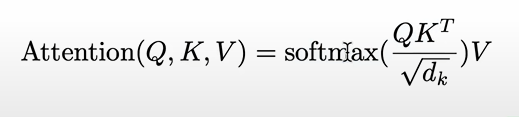

In [36]:
from IPython.display import Image
Image("self_attention.png")

In [37]:
# NOTE 1:
    # Attention is a communication mechanism, where we have a number of nodes in a directed graph where you basically have edges pointed between nodes like.
    # What happens is every node will have a vector of information and it gets to aggregate information via a weighted sum from all of the nodes that point to it. This is done in a data dependent manner.
    # So depending on whatever data is actually stored that you shouldn't at any point in time. 
    # Our graph doesn't look like a simlpe directed graph.
    # Our graph have 8 Node because our Time dimension is 8.
    # The first node point to itself.
    # The second node is pointed by first node and the second node itself.
    # The third node is pointed by first, second node and the third node itself. 
    # All the way up to 8th node. which is pointed by all the previous node and itself.
    # This is the structure our directed graph has or happens to have in Auto-Regressive sort of scenarios like language modeling.
    # But in priciple attention can be applied to any arbitrary directed graph and its just a communcation mechanism between the nodes.

# NOTE 2:
    # Attention has no notion of space, so attention simply acts over like a set of vectors in this graph and by default these node have no idea where they are positioned in the space.
    # That is why we need to encode them positionally and sort of give them some information that is anchored to its specific posiiton so that they know where they are.
    # And this is different than for example from convolution because if you're run for example a convolution operation over some input there's a very specific sort
    # of layout of the information in space and the convolutional filters sort of act in space. 
    # So it's not like an attention, In Attention is just a set of vectors out there in space they communicate and if you want them to have
    # a notion of space you need to specifically add it which is what we've done when we calculated the relative
    # the positional encodings and added that information to the vectors.

# NOTE 3:
    # The elements across Batch dimension which are independent examples never talk to each other and they're always processed independently.
    # In our examples there are 4 batches and 8 nodes so 32 nodes in total. But only every 8 nodes talk to each other not the whole 32 nodes talk to each other.

# NOTE 4:
    # In language modeling we have this specific structure of directed graph where the future tokens will not
    # communicate to the Past tokens but this doesn't necessarily have to be the constraint in the general case and in
    # fact in many cases you may want to have all of the nodes to talk to each other fully. 
    # So as an example if you're doing sentiment analysis or something like that with a Transformer you might have a number of tokens and you may want to
    # have them all talk to each other fully because later you are predicting for example the sentiment of the sentence
    # and so it's okay for these nodes to talk to each other and so in those cases you will use an encoder block of self
    # attention and uh all it means that it's an encoder block is that you will delete this line (wei = wei.masked_fill(tril==0, float('-inf')) of code allowing all the nodes
    # to completely talk to each other what we're implementing here is sometimes called a decoder block and it's called a
    # decoder because it is sort of like a decoding language and it's got this
    # autor regressive format where you have to mask with the Triangular Matrix so that uh nodes from the future never talk
    # to the Past because they would give away the answer and so basically in encoder blocks you
    # would delete this allow all the noes to talk in decoder blocks this will always be present so that you have this
    # triangular structure uh but both are allowed and attention doesn't care attention supports arbitrary connectivity between nodes the next.

# NOTE 5:
    # thing I wanted to comment on is you keep me you keep hearing me say attention self attention Etc there's actually also
    # something called cross attention what is the difference so basically the reason this attention
    # is self attention is because because the keys queries and the values are all
    # coming from the same Source from X so the same Source X produces Keys queries
    # and values so these nodes are self attending but in principle attention is
    # much more General than that so for example an encoder decoder Transformers uh you can have a case where the queries
    # are produced from X but the keys and the values come from a whole separate external source and sometimes from
    # encoder blocks that encode some context that we'd like to condition on and so the keys and the values will
    # actually come from a whole separate Source those are nodes on the side and here we're just producing queries and
    # we're reading off information from the side so cross attention is used when there's a separate source of nodes we'd
    # like to pull information from tha source into our nodes and it's self attention if we just have nodes that would like to look at
    # each other and talk to each other so this attention here happens to be self
    # attention but in principle attention is a lot more General.

# NOTE 6:
    # Refer the image.
    # Scaled self attending.

# NOTE 7:
    # 

## Self attention added code

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        # perform the weightes aggregation of the values.
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.sa_head(x) # Apply one head of self attention.
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.3263, val loss 4.3209
step 300: train loss 3.0875, val loss 3.1149
step 600: train loss 2.9221, val loss 2.9380
step 900: train loss 2.6395, val loss 2.6416
step 1200: train loss 2.5518, val loss 2.5447
step 1500: train loss 2.5003, val loss 2.5032
step 1800: train loss 2.4662, val loss 2.4752
step 2100: train loss 2.4606, val loss 2.4679
step 2400: train loss 2.4377, val loss 2.4557
step 2700: train loss 2.4422, val loss 2.4528
step 3000: train loss 2.4343, val loss 2.4273
step 3300: train loss 2.4149, val loss 2.4327
step 3600: train loss 2.4182, val loss 2.4227
step 3900: train loss 2.4050, val loss 2.4295
step 4200: train loss 2.4065, val loss 2.4142
step 4500: train loss 2.3942, val loss 2.4040
step 4800: train loss 2.3989, val loss 2.4021


IUbree, I tt ors the,
Hinlere Thad famy th th mith, chere amprast wim; mewinorof yofou huref ht t; ce isthe.
S:
OMus sa od,
LINou st prth hay fiere how,
T:
IT: et wow bam be ougr ow ca ter ay fo ch de fol:
Bu kl aveirdet-l

## Multi headed attention code added

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        # perform the weightes aggregation of the values.
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))

    def forward(self, x):
        return torch.cat([h(x)for h in self.heads], dim=-1)

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.sa_head = MultilHeadAttention(4, n_embd//4) # i.e. 4 heads od 8-dimensional self-attention.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.sa_head(x) # Apply one head of self attention.
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.3016, val loss 4.2970
step 300: train loss 2.8283, val loss 2.8341
step 600: train loss 2.5938, val loss 2.5937
step 900: train loss 2.5009, val loss 2.5000
step 1200: train loss 2.4624, val loss 2.4561
step 1500: train loss 2.4174, val loss 2.4202
step 1800: train loss 2.3842, val loss 2.3911
step 2100: train loss 2.3725, val loss 2.3773
step 2400: train loss 2.3519, val loss 2.3690
step 2700: train loss 2.3452, val loss 2.3598
step 3000: train loss 2.3373, val loss 2.3309
step 3300: train loss 2.3161, val loss 2.3359
step 3600: train loss 2.3102, val loss 2.3181
step 3900: train loss 2.3007, val loss 2.3173
step 4200: train loss 2.2934, val loss 2.3061
step 4500: train loss 2.2801, val loss 2.2903
step 4800: train loss 2.2745, val loss 2.2814


IUSS: now to or nrour:
Wheere you for hyou themiin, corent hof sef sont mes iphy Poon Yourefrrt thare isthe.
Sy own lovery, len wand prou hay fiere how,
Whimen erow with the ouge ow ca ter ay for whit fol:
But low, is
Ot-y

## MLP added

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        # perform the weightes aggregation of the values.
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))

    def forward(self, x):
        return torch.cat([h(x)for h in self.heads], dim=-1)

class FeedForward(nn.Module):
    """ a simple linear layer followed by non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x): # This is a token level and all token will do independently.
        return self.net(x)

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.sa_head = MultilHeadAttention(4, n_embd//4) # i.e. 4 heads od 8-dimensional self-attention.
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.sa_head(x) # Apply one head of self attention. (B, T, C)
        x = self.ffwd(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.1778, val loss 4.1788
step 300: train loss 2.8120, val loss 2.8172
step 600: train loss 2.5690, val loss 2.5662
step 900: train loss 2.4688, val loss 2.4658
step 1200: train loss 2.4251, val loss 2.4173
step 1500: train loss 2.3806, val loss 2.3793
step 1800: train loss 2.3444, val loss 2.3507
step 2100: train loss 2.3286, val loss 2.3332
step 2400: train loss 2.3051, val loss 2.3203
step 2700: train loss 2.2904, val loss 2.3056
step 3000: train loss 2.2901, val loss 2.2742
step 3300: train loss 2.2637, val loss 2.2829
step 3600: train loss 2.2540, val loss 2.2629
step 3900: train loss 2.2410, val loss 2.2566
step 4200: train loss 2.2421, val loss 2.2562
step 4500: train loss 2.2212, val loss 2.2341
step 4800: train loss 2.2134, val loss 2.2333


I bree, I to or I' amencell et.
Bur ame thy hame it, here ampfarst shat mestiroy your Yourefy. Whar,
Nitthelbfy owus sa of alence ithis of to fiere how,
Thime: eore with the of my wheanter ay for whit fol:
But low, is
O EN

## Added Blocks

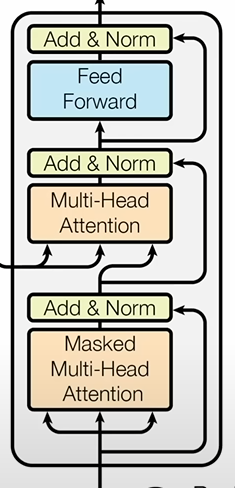

In [10]:
from IPython.display import Image
Image("block.png")

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        # perform the weightes aggregation of the values.
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))

    def forward(self, x):
        return torch.cat([h(x)for h in self.heads], dim=-1)

class FeedForward(nn.Module):
    """ a simple linear layer followed by non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x): # This is a token level and all token will do independently.
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like.
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultilHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4)
        )
        # self.sa_head = MultilHeadAttention(4, n_embd//4) # i.e. 4 heads od 8-dimensional self-attention.
        # self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.blocks(x)
        # x = self.sa_head(x) # Apply one head of self attention. (B, T, C)
        # x = self.ffwd(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.1861, val loss 4.1870
step 300: train loss 3.1983, val loss 3.2238
step 600: train loss 2.9870, val loss 2.9887
step 900: train loss 2.8336, val loss 2.8250
step 1200: train loss 2.6731, val loss 2.6745
step 1500: train loss 2.6141, val loss 2.6179
step 1800: train loss 2.5490, val loss 2.5515
step 2100: train loss 2.5044, val loss 2.5031
step 2400: train loss 2.4693, val loss 2.4551
step 2700: train loss 2.4359, val loss 2.4372
step 3000: train loss 2.4136, val loss 2.4106
step 3300: train loss 2.3984, val loss 2.3599
step 3600: train loss 2.3691, val loss 2.3600
step 3900: train loss 2.3453, val loss 2.3378
step 4200: train loss 2.3516, val loss 2.3279
step 4500: train loss 2.3178, val loss 2.3325
step 4800: train loss 2.3053, val loss 2.3106


IUUSNI:
Al:
I ring an:
Wile e Tked ther to the iin, I Xhe dours.

RAK:
Newindely yolouw gref he thare is delt yoow my a of alen went prounetor, and how,
Thime: erre with the ouge to canter ant,
Thicd chol:
Bcrals fucidet-w

In [12]:
# Since we use deep neural network they suffer from optimizations.
# Now we need to implement one more idea from the transformer paper.

# First - Residual Connection

In [13]:
# Now implemention is like we process the token embedding seperately from the original part and atlast adding the processed token with the original part.

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        # perform the weightes aggregation of the values.
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x)for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)
        )

    def forward(self, x): # This is a token level and all token will do independently.
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like.
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultilHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = x + self.sa(x) # Fork-off and do some computation and come back.
        x = x + self.ffwd(x) # Fork-off and do some computation and come back.
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4)
        )
        # self.sa_head = MultilHeadAttention(4, n_embd//4) # i.e. 4 heads od 8-dimensional self-attention.
        # self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.blocks(x)
        # x = self.sa_head(x) # Apply one head of self attention. (B, T, C)
        # x = self.ffwd(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.4080, val loss 4.4197
step 300: train loss 2.5000, val loss 2.5032
step 600: train loss 2.3689, val loss 2.3572
step 900: train loss 2.2866, val loss 2.2987
step 1200: train loss 2.2072, val loss 2.2334
step 1500: train loss 2.1882, val loss 2.2282
step 1800: train loss 2.1515, val loss 2.1881
step 2100: train loss 2.1232, val loss 2.1660
step 2400: train loss 2.1071, val loss 2.1642
step 2700: train loss 2.0749, val loss 2.1444
step 3000: train loss 2.0737, val loss 2.1130
step 3300: train loss 2.0485, val loss 2.1193
step 3600: train loss 2.0447, val loss 2.1051
step 3900: train loss 2.0321, val loss 2.0878
step 4200: train loss 2.0255, val loss 2.1049
step 4500: train loss 1.9971, val loss 2.0939
step 4800: train loss 1.9949, val loss 2.0961


ISA:
in I to or you mencell queked the you thee
in, I rent hofuse warn. Iwing hand love ure, he to courrd'!

Sousing your and now yet moother fiere how,
To me: ereequrray be of Go'd tanter art,
The deaus beectils fair
Ot-y

# Second - Layer Normalization 

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32 # How many independent sequence will we process in parallel?
block_size = 8 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        # perform the weightes aggregation of the values.
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x)for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)
        )

    def forward(self, x): # This is a token level and all token will do independently.
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like.
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultilHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # Fork-off and do some computation and come back.
        x = x + self.ffwd(self.ln2(x)) # Fork-off and do some computation and come back.
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.blocks = nn.Sequential(
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd),
        )
        # self.sa_head = MultilHeadAttention(4, n_embd//4) # i.e. 4 heads od 8-dimensional self-attention.
        # self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.blocks(x)
        # x = self.sa_head(x) # Apply one head of self attention. (B, T, C)
        # x = self.ffwd(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.2229, val loss 4.2282
step 300: train loss 2.5314, val loss 2.5293
step 600: train loss 2.3866, val loss 2.3682
step 900: train loss 2.2769, val loss 2.2844
step 1200: train loss 2.2078, val loss 2.2338
step 1500: train loss 2.1705, val loss 2.2066
step 1800: train loss 2.1432, val loss 2.1806
step 2100: train loss 2.1135, val loss 2.1496
step 2400: train loss 2.0920, val loss 2.1519
step 2700: train loss 2.0736, val loss 2.1452
step 3000: train loss 2.0610, val loss 2.0886
step 3300: train loss 2.0503, val loss 2.1095
step 3600: train loss 2.0297, val loss 2.0880
step 3900: train loss 2.0238, val loss 2.0743
step 4200: train loss 2.0141, val loss 2.0865
step 4500: train loss 1.9922, val loss 2.0776
step 4800: train loss 1.9824, val loss 2.0689


ICKENR, I to or you men:
Mere you for his to weit.

ICKING RICHAR:
Aret mest poy you hir tefth theare is detto you my a of all of you more to fier a dome but.

GRA:
I bay be orge to canter art,
To Rity oldsect low, is Ot--

# Scaling up the model - first code can be executed by 4050. It takes 15 min in A100

##### A100

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 64 # How many independent sequence will we process in parallel?
block_size = 256 # What is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x)for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x): # This is a token level and all token will do independently.
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like.
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultilHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # Fork-off and do some computation and come back.
        x = x + self.ffwd(self.ln2(x)) # Fork-off and do some computation and come back.
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # Final layer norm.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.blocks(x) # (B, T, C)
        x = self.ln_f(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

##### 4050

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Hyperparameters
batch_size = 32
block_size = 128
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256
n_head = 4
n_layer = 4
dropout = 0.2
# ---------------

torch.manual_seed(1377)

with open('tinyShakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Here are all the unique characters that occur in this text.
chars = sorted(list(set(text)))
vocab_size = len(chars)
# Create a mapping from characters to integers.
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # Encoder: Takes a string, outputs a list of integers.
decode = lambda l: ''.join([itos[i] for i in l]) # Decoder: Takes a list of integers, outputs a string.

# Train and Test splits.
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Data loading
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# The function we used before will calculate the loss for many batches.
# So that is a noisy measurement of the current loss because every batch will be more or less lucky.

@torch.no_grad() # This context manager will let know Pytroch that everything that happens inside this function will not call backward() function.  
                 # So Pytorch can be lot more efficent with its memory because it doesnt want to store all the intermediate variables happening inside because we will never call backward.
def estimate_loss(): # This function averages up the loss of multiple batches. This is a very less noisy measurement of loss.
    out = {}  # This function will return a pretty accurate loss on train and validation loss.
    model.eval() # Evaluation mode
    for split in  ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # Training mode. We just use this for practice. Right now nothing is gonna change. But some layer will have different behaviour like when inference time or training time.
    return out

class Head(nn.Module):
    """ one head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute attention scores 'affinities'.
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) ---> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) ---> (B, T, C)
        return out

class MultilHeadAttention(nn.Module):
    """ mutiple heads of self attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_heads))
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x)for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x): # This is a token level and all token will do independently.
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of head we'd like.
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultilHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # Fork-off and do some computation and come back.
        x = x + self.ffwd(self.ln2(x)) # Fork-off and do some computation and come back.
        return x

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table.
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # vocal size means the identity of the character.
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size means the position of the character.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # Final layer norm.
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers.
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C) This holds not just the token identity but also the positions at which these token occur.
        x = self.blocks(x) # (B, T, C)
        x = self.ln_f(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocal_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)  
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B,T) array of indices in the current context.
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens.
            idx_cond = idx[:, -block_size:] 
            # Get the Predictions.
            logits, loss = self(idx_cond)
            # Focus only on the last time step.
            logits = logits[:, -1, :] # Becomes (B,C).
            # Apply softmax to obtain the proabability.
            probs = F.softmax(logits, dim=-1) # (B,C)
            # Sample from the distribution.
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # Append sampled index to the running sequence.
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)

# Create a Pytorch Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss 
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 4.3041, val loss 4.3118
step 500: train loss 2.2091, val loss 2.2435
step 1000: train loss 1.8828, val loss 1.9817
step 1500: train loss 1.7023, val loss 1.8669
step 2000: train loss 1.6057, val loss 1.7984
step 2500: train loss 1.5378, val loss 1.7335
step 3000: train loss 1.4900, val loss 1.6984
step 3500: train loss 1.4592, val loss 1.6580
step 4000: train loss 1.4297, val loss 1.6253
step 4500: train loss 1.4076, val loss 1.6102

Thy lost allour! she big though woundsdoEd be
Vairt'st; and blood; and worny to sweat of His hable held do
sener: lone, ladce
what belf arms daughter deith: when it would?

This diend, this ue not that blose 'tis inhead:
My lipperant: hrift there are theseizeldies' wassed souls
In pastribbey agains telder'd and inhence own
stoist sweet the heats, of I lene one the woo;
He have have to rungone to knows, by the minstander;
Now this too; crest thouse to your and wrong.

DUKE WARD IV:
Ne't runt and 


##### Sampling

In [18]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))


Paen:' then from wrown fray Friatorance' turne
Be retently to Lords he uncluctured him withal speak
And witness those cutlious mester,
and my his bush tinefither's buster friend.

GLOUCESTER:
He near be as yonest, ittle thousat in the gattorans,
Tell me let fledge
Than of the both of muntty son: therefore feellock,
This mine, veiantructions and eyes bid in it?
We Cariol, sir, tell me with Topmen
while with coman cused the dewardices: it I dear,
Julant requittle comple, holly by dock that
reart only to haurds mother,
My privain neyI have a seny what reven.

MERCUTIO:
Trieed!

First Servant:
Let of goy. Good sire on same son.

First Citizen:
I would part he
This nair of traitor beak. Julrest
the comes: if this, we are, Wellcome salt thee tretchese
it in the son't; for who the whence, thus Edward.

First Senator:
Sas brother being thou Moweeps moke him liests?

NORTHUMBERLT:
Find you, my coke name too me.
Award we children, from me, Tutorth: yie, here antituna;
What, sping incrance my re